In [1]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
from collections import defaultdict
from urllib import request
import os
import pandas as pd
import numpy as np
from urllib import request
import cv2
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dropout,Dense
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
import os
from tensorflow.keras.applications import VGG16
import json
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
import tensorflow
import tensorflow as tf
from collections import deque

In [2]:
!pip install opencv.python
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install sklearn
!pip install requests


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install tqdm

In [5]:
file_path ="C:\\Users\\Al Amin\\Desktop\\rifat\\Cornleafdisease\\data"

In [6]:
!pip install split_folders

In [7]:
import splitfolders
splitted_folder='C:\\Users\\Al Amin\\Desktop\\rifat\\Cornleafdisease\\splitted_folder'
def train_test_valid(train_size=0.6,test_size=0.2,val_size=0.2,images_folder=file_path,splitted_folder=splitted_folder):
  train_size = train_size
  test_size = test_size
  val_size = val_size
  input_folder = images_folder
  output_folder = splitted_folder
  splitfolders.ratio(input_folder,output_folder, seed = 1337, ratio = (train_size,test_size,val_size), group_prefix = None)
train_test_valid()

Copying files: 4188 files [00:02, 1523.79 files/s]


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_file_path = 'C:\\Users\\Al Amin\\Desktop\\rifat\\Cornleafdisease\\splitted_folder\\train'
test_file_path =  'C:\\Users\\Al Amin\\Desktop\\rifat\\Cornleafdisease\\splitted_folder\\test'
val_file_path =  'C:\\Users\\Al Amin\\Desktop\\rifat\\Cornleafdisease\\splitted_folder\\val'

def data_pre_processing(valid_split = 0,input_size = (260, 260),image_color = 'rgb',batch_size = 32,
                        shuffle=True):


    train_gen=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split,fill_mode='nearest',rotation_range=40,horizontal_flip=True)

    validation_gen=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split)

    test_gen=ImageDataGenerator(rescale=1/255.0)

    train_data=train_gen.flow_from_directory(directory=train_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
    test_data=test_gen.flow_from_directory(directory=test_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
    valid_data=validation_gen.flow_from_directory(directory=val_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')

    return train_data,test_data,valid_data

train,test,validation=data_pre_processing()


Found 2511 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


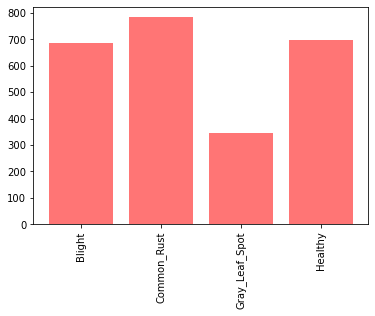

In [9]:
values_counter=Counter(train.classes)
sorted(values_counter.items())
plt.bar(train.class_indices.keys(), values_counter.values(), color=(1, 0.1, 0.1, 0.6))
plt.xticks(rotation=90)
plt.show()

In [10]:
labels=dict()
for label_name,label_num in train.class_indices.items():
        labels[label_num]=label_name

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.94it/s]


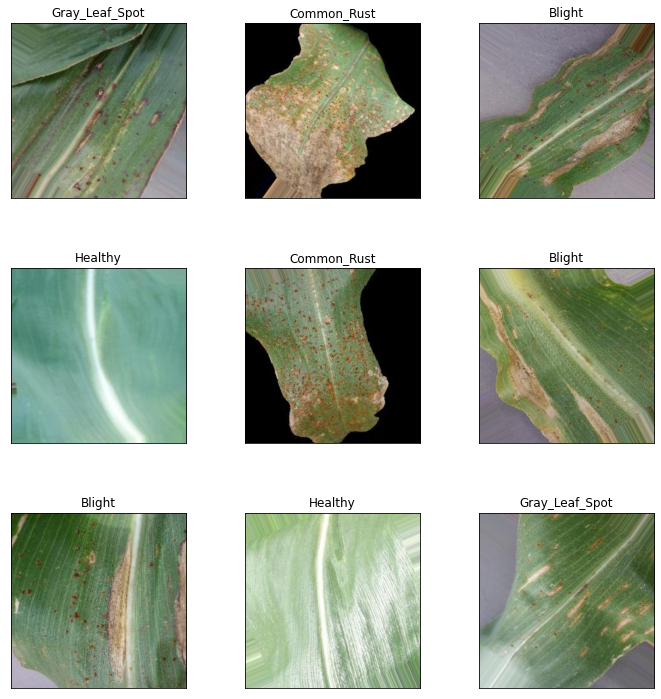

In [11]:
plt.figure(figsize=(10,10))
for i in tqdm(range(9)):
    plt.subplot(3,3,i+1)
    for x_batch,y_batch in train:
        image=x_batch[0]
        argmax=np.argmax(y_batch)
        plt.tight_layout(h_pad=5)
        plt.title(labels[argmax])
        plt.xticks(())
        plt.yticks(())
        plt.imshow(image)
        break

In [12]:
!pip install  efficientnet
import efficientnet.tfkeras as enet

In [15]:
def configure_model():
  inputs_1 = tf.keras.Input(shape=(260, 260, 3))
  mymodel=enet.EfficientNetB2(input_shape = (260, 260, 3), include_top = False, weights = 'imagenet')
  x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(mymodel.output)
  x = tf.keras.layers.Flatten()(x)
  predictors = tf.keras.layers.Dense(4,activation='softmax',name='Predictions')(x)
  final_model = Model(mymodel.input, outputs=predictors)
  return final_model
final_model=configure_model()

31948800/31936256 [==============================] - 97s 3us/step


In [16]:
def model(new_model=final_model,layers_num=1,trainable=False):
    for layer in new_model.layers[:layers_num]:
        layer.trainable=trainable
    return new_model
final_model=model(final_model)

In [17]:
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [18]:
opt=tf.keras.optimizers.Adam(0.0001)
final_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
def callbacks(patience=2):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('my_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,min_delta=0.001)
    lr=tf.keras.callbacks.LearningRateScheduler(scheduler)
    callbacks_list=[checkpoint, early,lr]
    return callbacks_list

In [20]:
callbacks=callbacks()

In [21]:
counter = Counter(train.classes)                          
max_val = float(max(counter.values()))       
class_weights1 = {class_id : max_val/num_images for class_id, num_images in counter.items()}  

In [22]:
hist=final_model.fit(train,epochs=1000,validation_data=(validation),callbacks=callbacks,class_weight=class_weights1)

Epoch 1/1000
79/79 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.8228
Epoch 1: val_loss improved from inf to 0.53969, saving model to my_model.h5
79/79 [==============================] - 429s 5s/step - loss: 0.6843 - accuracy: 0.8228 - val_loss: 0.5397 - val_accuracy: 0.7895 - lr: 1.0000e-04
Epoch 2/1000
79/79 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.9327
Epoch 2: val_loss improved from 0.53969 to 0.31589, saving model to my_model.h5
79/79 [==============================] - 419s 5s/step - loss: 0.2367 - accuracy: 0.9327 - val_loss: 0.3159 - val_accuracy: 0.8852 - lr: 1.0000e-04
Epoch 3/1000
79/79 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9526
Epoch 3: val_loss improved from 0.31589 to 0.20784, saving model to my_model.h5
79/79 [==============================] - 419s 5s/step - loss: 0.1827 - accuracy: 0.9526 - val_loss: 0.2078 - val_accuracy: 0.9270 - lr: 1.0000e-04
Epoch 4/1000
79/79 [===============

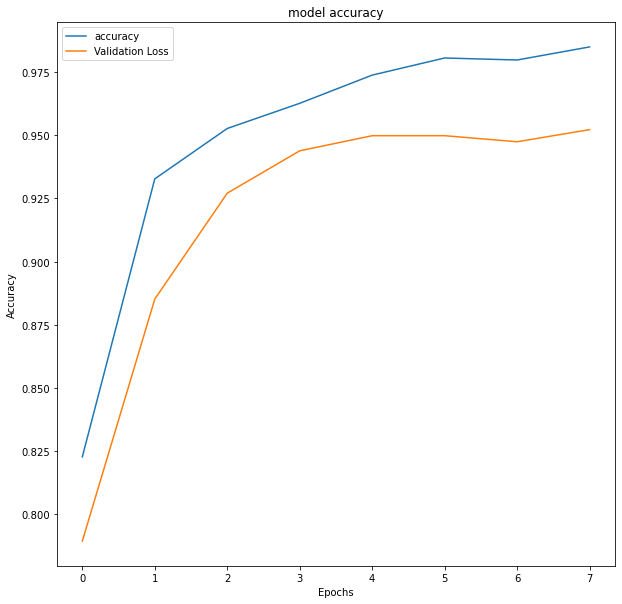

In [31]:
plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")                  
plt.legend(["accuracy","Validation Loss"])
plt.show()

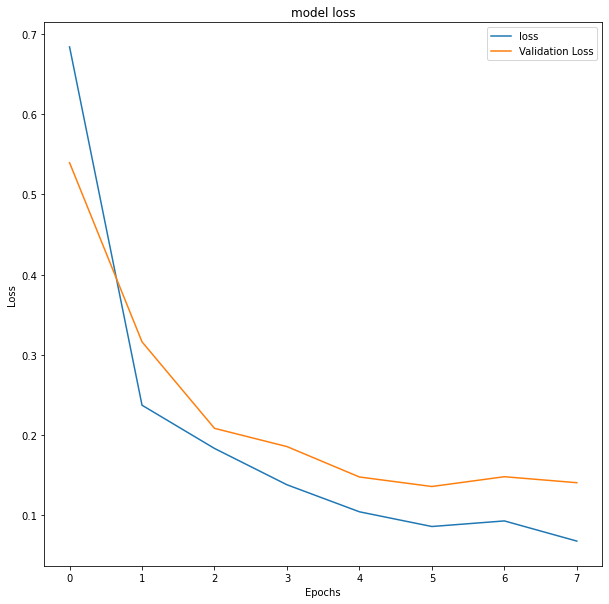

In [32]:
plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["loss","Validation Loss"])
plt.show()

In [33]:
y_real=[]
all_pred=[]
count=0
for x,y in test:
  predict=final_model.predict(x)
  
  for i in predict:
    all_pred.append(np.argmax(i)+1)
  for i in y:
    i=np.argmax(i)+1
    y_real.append(i)

  if len(y_real)==len(test.filepaths):
    break

In [34]:
target_names =[]
for key,value in test.class_indices.items():
  target_names.append(f'condition: {key}')

In [41]:
from sklearn import metrics
report=metrics.classification_report(y_real,all_pred,target_names=target_names)
conf_efficnet2=metrics.confusion_matrix(y_real,all_pred)

In [47]:
import itertools
def plot_confusion_matrix(cnf_matrix, numbers_type='numbers_and_percentage', class_names=target_names, title='Confusion matrix', cmap=plt.cm.Blues, file_name='confusionmatrix.png'):
    combined = True
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = 0.8*cnf_matrix.max() / 1.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if numbers_type == 'numbers_and_percentage':
            st1 = '{:.2f}%'.format(100 * cnf_matrix_normalized[i, j])
            st2 = '({:2d})'.format(cnf_matrix[i, j])
            plt.text(j, i, st1+st2,
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

        elif numbers_type == 'percentage':
            fmt = '.2f'
            plt.text(j, i, format(cnf_matrix_normalized[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        else:
            fmt = 'd'
              plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(file_name)

    return

IndentationError: unexpected indent (Temp/ipykernel_4612/2035761899.py, line 28)

In [38]:
plot_confusion_matrix(conf_efficnet2)

NameError: name 'plot_confusion_matrix' is not defined